## Image segmentation with CamVid
http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/

In [1]:
#!pip install fastai --upgrade

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.collect_env import *
show_install()
#torch.cuda.set_device(3)



```text
=== Software === 
python        : 3.6.5
fastai        : 1.0.42
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 396.54
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.4.0-1049-aws-x86_64-with-debian-stretch-sid
distro        : #58-Ubuntu SMP Fri Jan 12 23:17:09 UTC 2018
conda env     : Unknown
python        : /usr/local/bin/python
sys.path      : /usr/local/lib/python36.zip
/usr/local/lib/python3.6
/usr/local/lib/python3.6/lib-dynload

/usr/local/lib/python3.6/site-packages
/usr/local/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg
/usr/local/lib/python3.6/site-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be insta

In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/floyd/home/fastai/data/camvid/labels'),
 PosixPath('/floyd/home/fastai/data/camvid/valid.txt'),
 PosixPath('/floyd/home/fastai/data/camvid/images'),
 PosixPath('/floyd/home/fastai/data/camvid/codes.txt')]

In [6]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [7]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [8]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/floyd/home/fastai/data/camvid/images/0001TP_007800.png'),
 PosixPath('/floyd/home/fastai/data/camvid/images/0016E5_02250.png'),
 PosixPath('/floyd/home/fastai/data/camvid/images/0016E5_06960.png')]

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/floyd/home/fastai/data/camvid/labels/Seq05VD_f01200_P.png'),
 PosixPath('/floyd/home/fastai/data/camvid/labels/0001TP_007740_P.png'),
 PosixPath('/floyd/home/fastai/data/camvid/labels/0016E5_04440_P.png')]

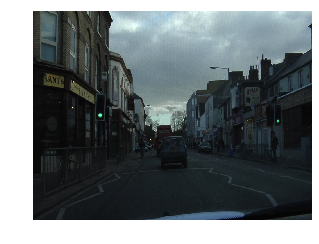

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

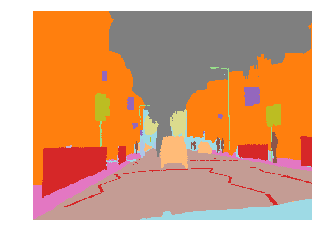

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

`codes` are the mapping between the ints in the mask and the material

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets
We use a batch size of only 8 as segmentation is very intensive on GPU -> I notice that even this value is maxing out the GPU ram on my machine..

In [15]:
size = src_size//2
bs=8
# bs=4 # try 4 as 8 was maxing my ram. Ok this used 50% or RAM so appears bs=8 is optimal

This dataset provides validation images in `valid.txt` -> as these images are from a video sequenc have to be careful not to mix adjacent frames in train and validation samples

In [17]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [18]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

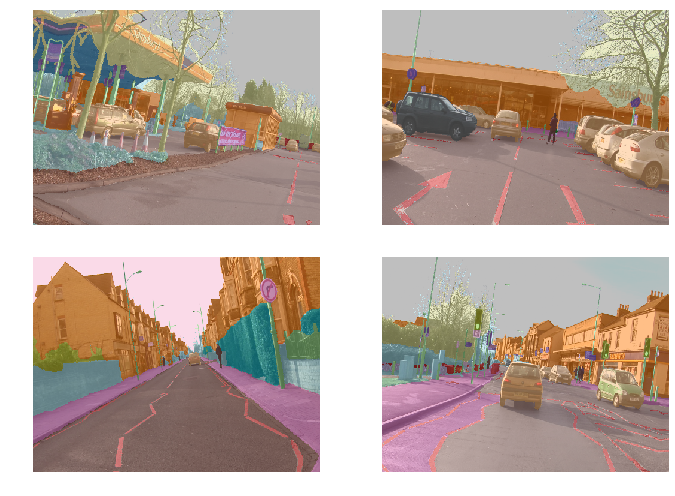

In [19]:
data.show_batch(2, figsize=(10,7))

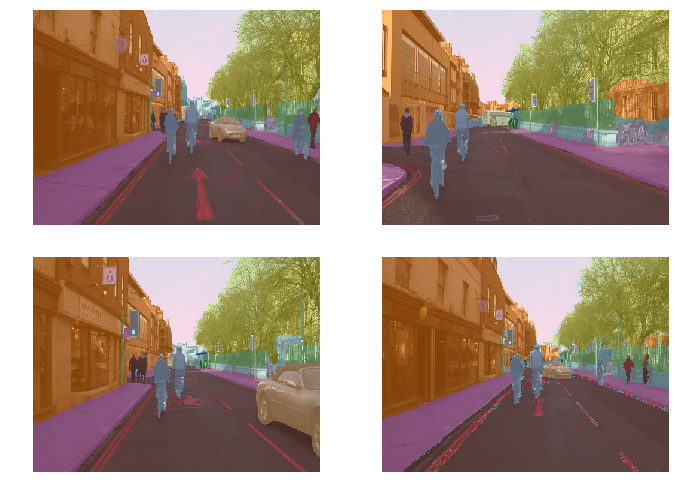

In [20]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model
For segmentation we use a UNET

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [22]:
metrics=acc_camvid
# metrics=accuracy

In [23]:
wd=1e-2

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


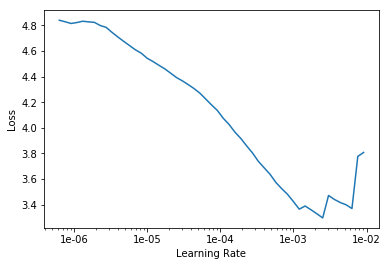

In [25]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

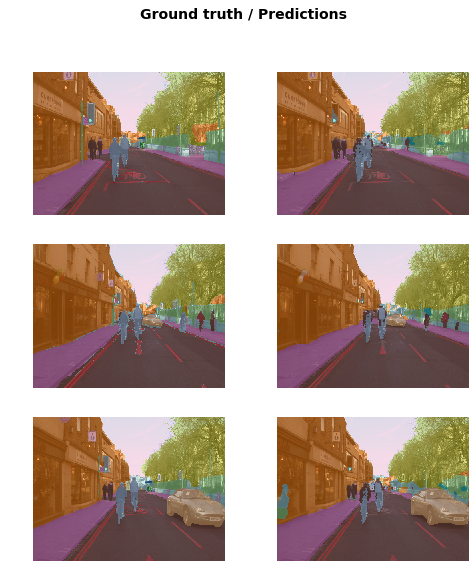

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

Give an `increasing` learning rate

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

Total time: 05:41
epoch  train_loss  valid_loss  acc_camvid
1      0.371151    0.299532    0.913073    (00:28)
2      0.366780    0.294742    0.912834    (00:28)
3      0.358645    0.289903    0.914587    (00:28)
4      0.343787    0.283344    0.917667    (00:28)
5      0.335654    0.302039    0.910359    (00:28)
6      0.333715    0.279829    0.917886    (00:28)
7      0.319299    0.280948    0.919826    (00:28)
8      0.322344    0.307531    0.903787    (00:28)
9      0.308014    0.262560    0.925540    (00:28)
10     0.304060    0.293154    0.914199    (00:28)
11     0.285894    0.261870    0.923825    (00:28)
12     0.260680    0.255957    0.926067    (00:28)



In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=3

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


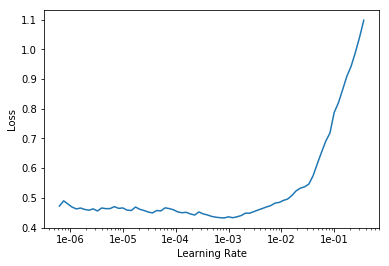

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

Total time: 15:41
epoch  train_loss  valid_loss  acc_camvid
1      0.382982    0.337384    0.904437    (01:40)
2      0.363525    0.312738    0.913709    (01:33)
3      0.345842    0.281208    0.918837    (01:33)
4      0.332908    0.315401    0.911936    (01:33)
5      0.337121    0.315564    0.911719    (01:33)
6      0.326914    0.283248    0.919347    (01:33)
7      0.311748    0.303021    0.913213    (01:33)
8      0.312433    0.264381    0.925357    (01:33)
9      0.274042    0.265071    0.921500    (01:33)
10     0.244084    0.239709    0.931215    (01:33)



In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

Total time: 16:49
epoch  train_loss  valid_loss  acc_camvid
1      0.224315    0.243748    0.929659    (01:39)
2      0.233819    0.256230    0.925163    (01:41)
3      0.216598    0.248363    0.929304    (01:41)
4      0.217467    0.242487    0.930903    (01:41)
5      0.221290    0.247053    0.930387    (01:41)
6      0.208421    0.249250    0.929263    (01:41)
7      0.202845    0.240715    0.931511    (01:41)
8      0.197734    0.244688    0.930260    (01:41)
9      0.195650    0.249368    0.929931    (01:40)
10     0.192460    0.248666    0.929322    (01:41)



In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

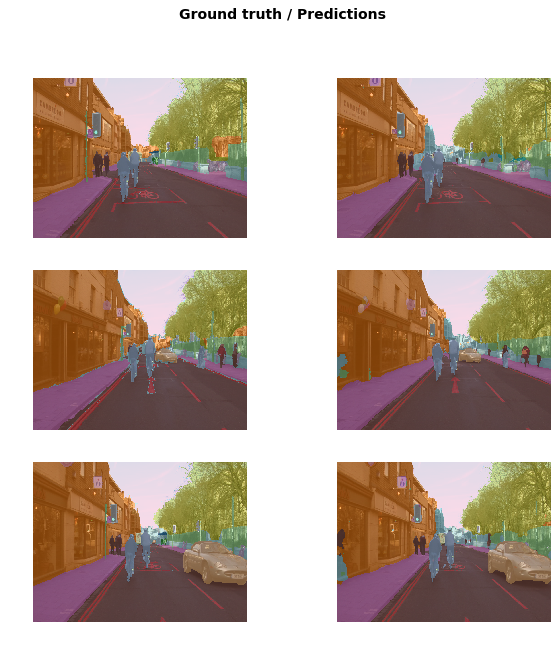

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin